# Finding the Optimal Media Strategy

Brooks and Porter defined a media impact statistic by computing the statistic:
\begin{equation}
R = \frac{1}{N} \sum \|x_i^* - x_M \|_2,
\end{equation}
where $x_i^*$ is the ideology of the $i$th non-media account at convergence and $x_M$ is the common ideology of all media accounts. The mean baseline ideological distance is computed by omitting the media accounts from the simulation, and averaging over a large number of trials. 
\begin{equation}
R_M = \frac{R_0}{R}
\end{equation}
of the effect of the media on the ideology of the non-media accounts in the network. For a given network structure, This may be averaged over many samples to give an estimate of the overall effect of a certain amount of media influence. Somewhat surprisingly, they found that for most networks, including the natural network structures obtained from mid-2000s college Facebook networks, the media impact is not always increased by increasing the number of media accounts or their follower counts. Instead, the highest media impact is usually found along a curve in the (accounts, followers/account) plane.

In this notebook, we attempt to replicate this result and extend it in two ways. First, we attempt to estimate the maximum-impact curve and provide an intuitive explanation for its existence. Second, we explore the case where there are multiple competing media ideologies instead of all media accounts sharing a common ideological position.

## Replication of Existing Results

In [1]:
# imports and includes
using LightGraphs, MetaGraphs, SNAPDatasets, Random, GraphPlot, Compose, Plots
include("../src/models.jl")   # Graph models
include("../src/dynamics.jl") # Dynamical systems
include("../src/dataviz.jl")  # Plotting for our graphs

drawcolorgraph (generic function with 1 method)

Brooks and Porter explored several synthetic graph models as well as real social network structures. 

### Erdos-Renyi graphs, directed and undirected

We consider Erdos-Renyi networks with $N = 1000$ vertices and mean degree (out-degree for directed graphs) 25.

#### Single trial example

In [2]:
Random.seed!(1534)
g = ermodel(500, 0.05, IGraph)
M = 0.9 # Media ideological position
# Compute mean baseline ideological distance
n_trials = 50
R = zeros(n_trials)
@time for i=1:n_trials
    assignid!(g)
    fullsim!(g, 0.5)
    for j = 1:nv(g.g)
        R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
    end
end
mean_R₀ = sum(R) / n_trials

  9.619274 seconds (114.56 M allocations: 11.855 GiB, 19.88% gc time)


0.8985929635481004

In [3]:
# Add 20 media accounts with 20 followers each
addmedia_rand!(g, 20, 20, M)
n_trials = 50
R = zeros(n_trials)
@time for i=1:n_trials
    assignid!(g)
    fullsim!(g, 0.5)
    for j = 1:nv(g.g)
        R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
    end
end
mean_R = sum(R) / n_trials
mean_R₀ / mean_R

  7.404269 seconds (133.35 M allocations: 14.010 GiB, 16.26% gc time)


1.1108214100218186

In [4]:
function R_er(N, M, mean_degree, n_media, n_followers, n_trials)
    g = ermodel(N, 25 / N, IGraph)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
            R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R₀ = sum(R) / n_trials
    addmedia_rand!(g, n_media, n_followers, M)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
        R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R = sum(R) / n_trials
    mean_R₀ / mean_R
end

R_er (generic function with 1 method)

In [5]:
R_er(100, 0.9, 30, 30, 200)

MethodError: MethodError: no method matching R_er(::Int64, ::Float64, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  R_er(::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[4]:2

In [6]:
R_mat = zeros(20, 20)
for n_media = 1:20
    for n_followers = 1:20
        R_mat[n_media, n_followers] = R_er(100, 0.9, n_media, n_followers, 100)
    end
end
R_mat

MethodError: MethodError: no method matching R_er(::Int64, ::Float64, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  R_er(::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[4]:2

In [7]:
#heatmap(R_mat)

### Natural network structures

#### Facebook100 data set

Now, we use the Reed College Facebook network from September 2005.

In [10]:
function R_reed(n_media, n_followers, n_trials)
    g = fbgraph("Reed98", IGraph)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
            R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R₀ = sum(R) / n_trials
    addmedia_rand!(g, n_media, n_followers, M)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
        R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R = sum(R) / n_trials
    mean_R₀ / mean_R
end
R_reed(11, 225, 1)

1.674282619311616

In [11]:
@time R_reed(11, 10, 2)

 48.400164 seconds (916.59 M allocations: 104.369 GiB, 16.32% gc time)


1.0070993351156488

In [14]:
R_mat = zeros(25, 25)
@time for n_media = 1:25
    for n_followers = 1:25
        print("Working on entry ", n_media, ",", n_followers)
        R_mat[n_media, n_followers] = R_reed(n_media, n_followers, 100)
    end
end
R_mat

Working on entry 1,1Working on entry 1,2Working on entry 1,3Working on entry 1,4Working on entry 1,5Working on entry 1,6Working on entry 1,7Working on entry 1,8Working on entry 1,9Working on entry 1,10Working on entry 1,11Working on entry 1,12Working on entry 1,13Working on entry 1,14Working on entry 1,15Working on entry 1,16Working on entry 1,17Working on entry 1,18Working on entry 1,19Working on entry 1,20Working on entry 1,21Working on entry 1,22Working on entry 1,23Working on entry 1,24Working on entry 1,25Working on entry 2,1Working on entry 2,2Working on entry 2,3Working on entry 2,4Working on entry 2,5Working on entry 2,6Working on entry 2,7Working on entry 2,8Working on entry 2,9Working on entry 2,10Working on entry 2,11Working on entry 2,12Working on entry 2,13Working on entry 2,14Working on entry 2,15Working on entry 2,16Working on entry 2,17Working on entry 2,18Working on entry 2,19Working on entry 2,20Working on entry 2,21Working on entry 2,22Working on entry 2,23Working on

InterruptException: InterruptException:

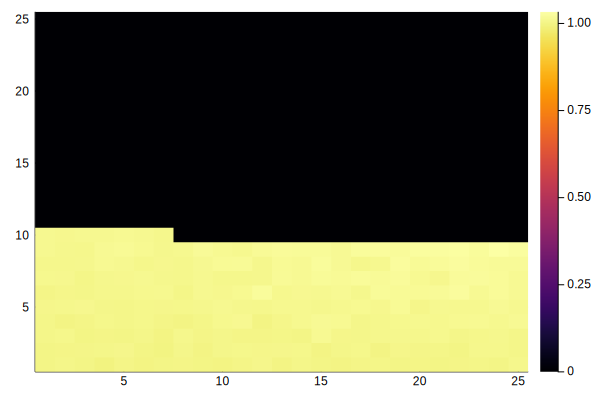

In [17]:
heatmap(R_mat)

In [15]:
function R_smith(n_media, n_followers, n_trials)
    g = fbgraph("Smith60", IGraph)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
            R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R₀ = sum(R) / n_trials
    addmedia_rand!(g, n_media, n_followers, M)
    R = zeros(n_trials)
    for i=1:n_trials
        assignid!(g)
        fullsim!(g, 0.5)
        for j = 1:nv(g.g)
        R[i] += g.distance(props(g.g, j)[:ideology], M) / nv(g.g)
        end
    end
    mean_R = sum(R) / n_trials
    mean_R₀ / mean_R
end

R_smith (generic function with 1 method)

In [16]:
Smith_mat = zeros(25, 25)
@time for n_media = 1:25
    for n_followers = 1:25
        print("Working on entry ", n_media, ",", n_followers)
        Smith_mat[n_media, n_followers] = R_smith(n_media, n_followers, 100)
    end
end
Smith_mat

Working on entry 1,1

InterruptException: InterruptException:

## What's that curve?

## Multiple media ideologies

In the real world, of course, not all media influence comes from the same ideological position. Indeed, a major goal of this research is to better understand the effect of divergent media ideology on the formation of so-called "echo chambers."

In order to characterize media impact in the multipolar media setting, we must define new metrics of media impact, since the statistic $R$ defined in the beginning of this notebook is defined in terms of distance from a single media ideology.

#### Average Distance Impact

Similar to the statistic $R$ defined before, we define the *average distance impact* statistic by averaging the ideological distance between each individual's account at convergence with and without media presence.
\begin{equation}
R = \frac{1}{N} \sum_{i=1}^N \|x_i^* - x_i^{*(0)}\|_2
\end{equation}
where $x_i^*$ is the ideology of the *i*th non-media account at convergence in the presence of media, and $x_i^{*(0)}$ is the same account's ideology at convergence without all media accounts.

#### Mean Ideological Position

A very simple way to measure a media position's "success" in capturing the aggregate population is to compute the mean ideological position of all non-media accounts.

#### Follower Entrainment

Finally, we define several metrics for absolute and relative follower entrainment. A simple metric is $\hat p_E$, the proportion of non-media accounts that are near the media account's ideology; as a first approximation, we consider "near" to mean within $2\varepsilon$, where $\varepsilon$ is the simulation convergence tolerance. For a more nuanced measurement, we can compute $F(x; x_M)$, the cumulative distribution function for the distance of non-media accounts from the media ideology $x_M$. The relative media entrainment of two media ideologies $x_M, x_N$ is measured by
\begin{equation}
    \int_0^\infty (F(x; x_M) - F(x; x_N)) dx.
\end{equation}